## Post Sentiment Classification Task

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import nltk
from nltk.stem import WordNetLemmatizer 
import scipy as sp

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

# **Count Plot**

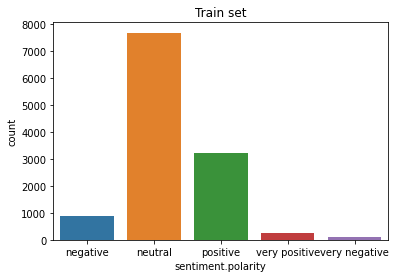

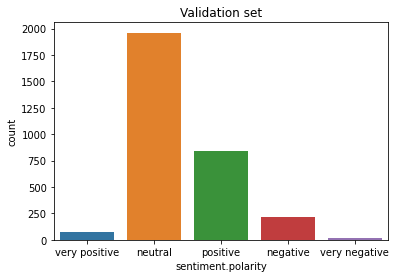

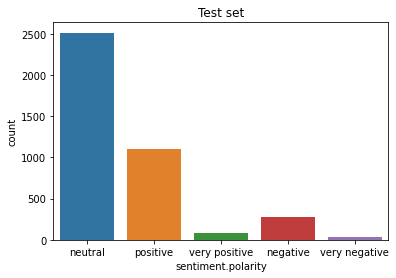

In [2]:
a=0
datasets = [train_data, validation_data, test_data] 
titles = ['Train set','Validation set','Test set']
for i in datasets:
    plt.title(titles[a])
    sns.countplot( x= 'sentiment.polarity', data = i)
    plt.show()
    a+=1

**Length of each data set**

In [3]:
a= 0 
for i in datasets:
    print('{} contains {} reviews'.format(titles[a],len(i)))
    print('The distribution of reviews are as follows,')
    print(i['sentiment.polarity'].value_counts())
    print('\n')
    a+=1

Train set contains 12138 reviews
The distribution of reviews are as follows,
neutral          7679
positive         3231
negative          878
very positive     253
very negative      97
Name: sentiment.polarity, dtype: int64


Validation set contains 3109 reviews
The distribution of reviews are as follows,
neutral          1961
positive          845
negative          215
very positive      73
very negative      15
Name: sentiment.polarity, dtype: int64


Test set contains 4016 reviews
The distribution of reviews are as follows,
neutral          2514
positive         1102
negative          282
very positive      86
very negative      32
Name: sentiment.polarity, dtype: int64




In [58]:
#Visualising the distribution
train = train_data['sentiment.polarity'].value_counts()
test = test_data['sentiment.polarity'].value_counts()
val = validation_data['sentiment.polarity'].value_counts()

df = pd.DataFrame(train)
df['test']= pd.DataFrame(test)
df['val']= pd.DataFrame(val)

df = df.reset_index()
df.columns= ['sentiment','Train','Test','Validation']

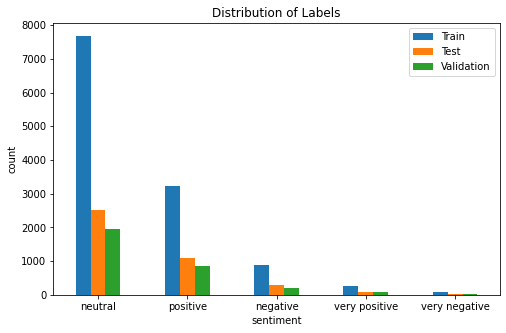

In [59]:
df.plot(x = 'sentiment',y = ['Train','Test','Validation'],kind='bar',figsize=(8,5),rot=0)
plt.ylabel('count')
plt.title('Distribution of Labels')
plt.show()

**Importing Spacy**

In [6]:
# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list

nltk.download('stopwords')
nltk.download('wordnet')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Tokenize and Normalize**

In [7]:
lemmatizer = WordNetLemmatizer()
#Tokenize
def spacy_tokenize(string):
    tokens = list()
    #string = " ".join(w for w in nltk.wordpunct_tokenize(string) if lemmatizer.lemmatize(w.lower()) in words or not w.isalpha())
    doc = nlp(string)
    for token in doc: 
        tokens.append(token)
    return tokens

#Normalize and Lemmatize
def normalize(tokens):
    normalized_tokens = list()
    for token in tokens:
        normalized = token.text.lower().strip()
        if (token.is_alpha or token.is_digit):
            normalized_tokens.append((normalized))
    return normalized_tokens

#Tokenize and normalize
def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

**Count Vectorizer One-hot encoding**

In [8]:
one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
train_features = one_hot_vectorizer.fit_transform(train_data['body'])

# This creates input features for our classification on all subsets of our collection.
validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

pd.DataFrame(train_features.toarray(), columns = one_hot_vectorizer.get_feature_names())

,0,00,000,0000,00005401,00005402,00005404,00005405,00005406,00005407,...,zyra,zyxel,zzbfbm,zābaki,águila,ļoti,ō,ψ,武田信玄,סּ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Count Vectorizer with TF-IDF vectorizer**

In [9]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize)

# This creates input features for our classification on all subsets of our collection.
train_features_tfidf = tf_idf_vectorizer.fit_transform(train_data['body'])
validation_features_tfidf = tf_idf_vectorizer.transform(validation_data['body'])
test_features_tfidf = tf_idf_vectorizer.transform(test_data['body'])

pd.DataFrame(train_features_tfidf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

,0,00,000,0000,00005401,00005402,00005404,00005405,00005406,00005407,...,zyra,zyxel,zzbfbm,zābaki,águila,ļoti,ō,ψ,武田信玄,סּ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Label Encoding**

In [10]:
#One hot encoding the target 
le = LabelEncoder()
train_labels = le.fit_transform(train_data['sentiment.polarity'])
validation_labels = le.transform(validation_data['sentiment.polarity'])
test_labels = le.transform(test_data['sentiment.polarity'])

#Print the encoded classes 
le.classes_

array(['negative', 'neutral', 'positive', 'very negative',
       'very positive'], dtype=object)

# **Evaluation Metrics**

In [11]:
# This function takes in the training prediction and test prediction and provied confusion matrix and classification report
def evaluation_summary(description, train_pred, train_labels, y_pred, test_labels,train_features,test_features,clf):
    print('\t\t \033[1m'+ description + '\033[0m')
    print("\n\t\tEvaluation for training set \n")
    print(classification_report(train_pred, train_labels, digits=3, zero_division = 0, target_names=le.classes_))
    print('\nConfusion matrix for train set')
    
    #ploting the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_confusion_matrix(clf, train_features, train_labels,display_labels=le.classes_,ax=ax)  
    plt.show()
    
    
    print("\n\t\tEvaluation for test set \n")
    print(classification_report(y_pred, test_labels, digits=3, zero_division = 0, target_names=le.classes_))
    print('\nConfusion matrix for test set')
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_confusion_matrix(clf, test_features, test_labels,display_labels=le.classes_,ax=ax)  
    plt.show()

**Dummy Classifier**

 **Dummy Classifier with strategy "stratified"**

		 Dummy Classifier-Stratified

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.073     0.073     0.073       878
      neutral      0.632     0.631     0.632      7688
     positive      0.258     0.259     0.258      3216
very negative      0.021     0.018     0.019       111
very positive      0.036     0.037     0.036       245

     accuracy                          0.475     12138
    macro avg      0.204     0.204     0.204     12138
 weighted avg      0.475     0.475     0.475     12138


Confusion matrix for train set


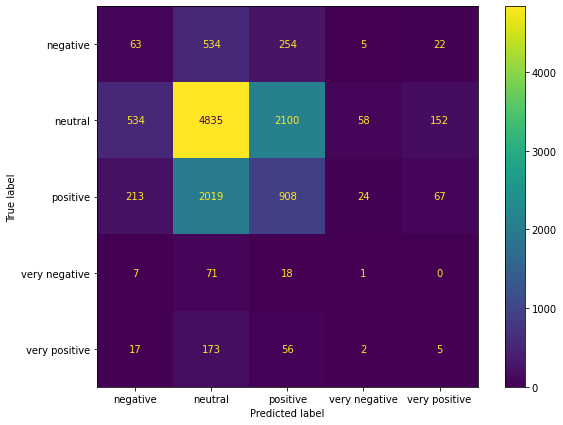


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.085     0.078     0.081       307
      neutral      0.639     0.634     0.636      2533
     positive      0.275     0.282     0.278      1075
very negative      0.000     0.000     0.000        25
very positive      0.023     0.026     0.025        76

     accuracy                          0.482      4016
    macro avg      0.204     0.204     0.204      4016
 weighted avg      0.483     0.482     0.483      4016


Confusion matrix for test set


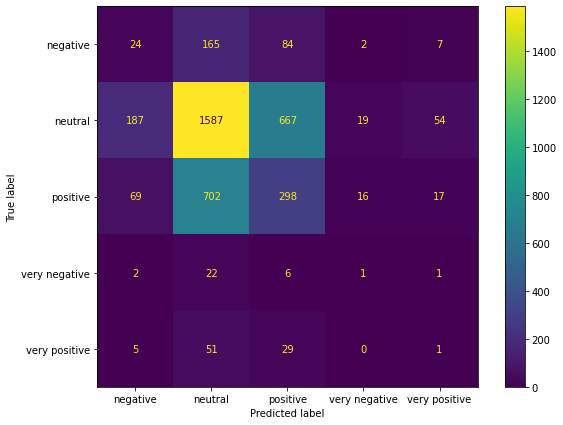

In [12]:
#Initialise 
dummy_prior = DummyClassifier(strategy='stratified')
#fit
dummy_prior.fit(train_features, train_labels) 
#predict on training data
train_pred = dummy_prior.predict(train_features)
#predict on test data
y_pred = dummy_prior.predict(test_features)
#print the report
evaluation_summary('Dummy Classifier-Stratified',train_pred,train_labels, y_pred,test_labels,train_features,test_features,dummy_prior)

**Dummy Classifier with strategy "most_frequent"**

		 Dummy Classifier-most_frequent

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.633     0.775     12138
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.633     12138
    macro avg      0.200     0.127     0.155     12138
 weighted avg      1.000     0.633     0.775     12138


Confusion matrix for train set


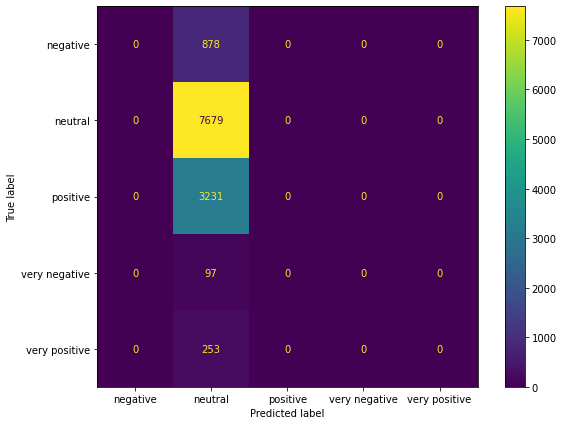


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.626     0.770      4016
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.626      4016
    macro avg      0.200     0.125     0.154      4016
 weighted avg      1.000     0.626     0.770      4016


Confusion matrix for test set


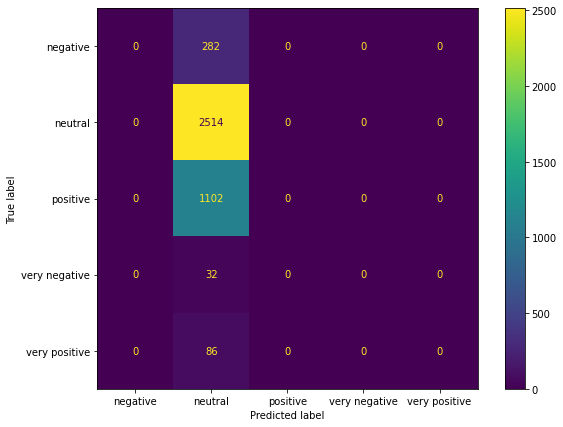

In [13]:
dummy_prior = DummyClassifier(strategy='most_frequent')
dummy_prior.fit(train_features, train_labels)
train_pred = dummy_prior.predict(train_features)
y_pred = dummy_prior.predict(test_features)
evaluation_summary('Dummy Classifier-most_frequent',train_pred,train_labels, y_pred,test_labels,train_features,test_features,dummy_prior)

**Logistic Regression with One hot vectorization**

		 Logistic Regression-one hot encoding

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.849     0.984     0.911       757
      neutral      0.995     0.952     0.973      8027
     positive      0.934     0.980     0.956      3080
very negative      0.629     1.000     0.772        61
very positive      0.834     0.991     0.906       213

     accuracy                          0.962     12138
    macro avg      0.848     0.981     0.904     12138
 weighted avg      0.966     0.962     0.963     12138


Confusion matrix for train set


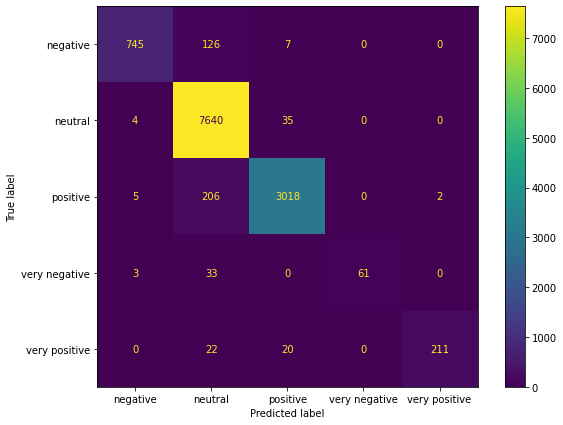


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.245     0.479     0.324       144
      neutral      0.875     0.778     0.824      2830
     positive      0.636     0.712     0.672       985
very negative      0.125     0.667     0.211         6
very positive      0.279     0.471     0.350        51

     accuracy                          0.747      4016
    macro avg      0.432     0.621     0.476      4016
 weighted avg      0.785     0.747     0.762      4016


Confusion matrix for test set


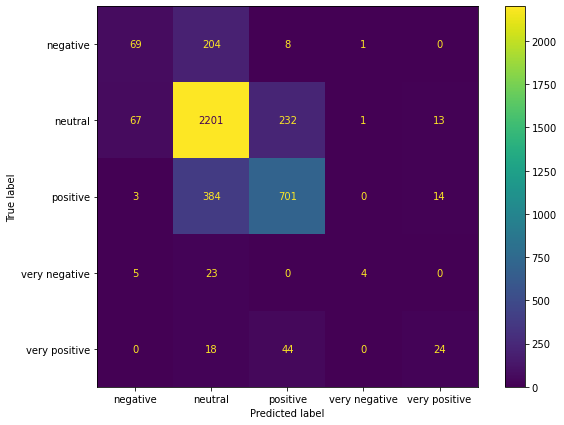

In [14]:
lr = LogisticRegression(solver='saga',max_iter = 1000)
lr_model = lr.fit(train_features, train_labels)
train_pred = lr_model.predict(train_features)
y_pred = lr_model.predict(test_features)
evaluation_summary('Logistic Regression-one hot encoding',train_pred,train_labels, y_pred,test_labels,train_features,test_features,lr_model)

**Logistic Regression with TF-IDF vectorization**

		 Logistic Regression-TF-IDF

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.187     0.911     0.310       180
      neutral      0.977     0.795     0.877      9440
     positive      0.677     0.890     0.769      2455
very negative      0.041     1.000     0.079         4
very positive      0.221     0.949     0.359        59

     accuracy                          0.817     12138
    macro avg      0.421     0.909     0.479     12138
 weighted avg      0.901     0.817     0.844     12138


Confusion matrix for train set


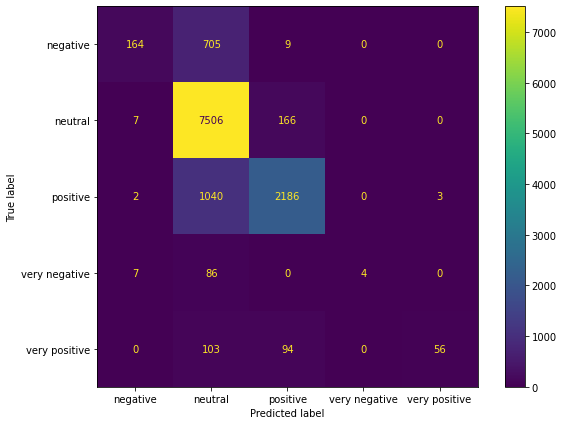


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.089     0.625     0.155        40
      neutral      0.944     0.738     0.828      3213
     positive      0.516     0.758     0.614       751
very negative      0.000     0.000     0.000         0
very positive      0.105     0.750     0.184        12

     accuracy                          0.741      4016
    macro avg      0.331     0.574     0.356      4016
 weighted avg      0.853     0.741     0.780      4016


Confusion matrix for test set


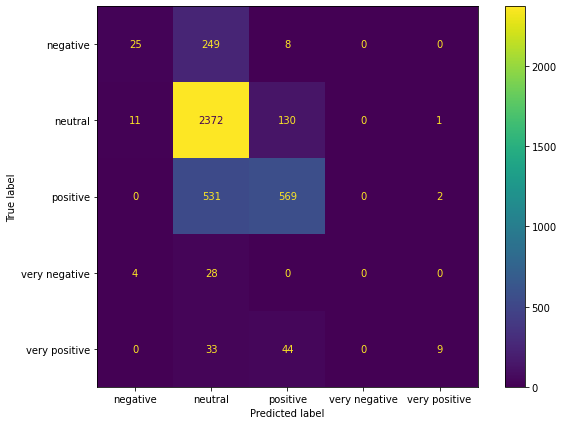

In [15]:
lr_tf_idf = lr.fit(train_features_tfidf, train_labels)
train_pred = lr_tf_idf.predict(train_features_tfidf)
y_pred = lr_tf_idf.predict(test_features_tfidf)
evaluation_summary('Logistic Regression-TF-IDF',train_pred, train_labels, y_pred,test_labels, train_features_tfidf,test_features_tfidf,lr_tf_idf)

**SVC Classifier with One-Hot Vectorization**

		 SVC-one hot

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.286     0.996     0.444       252
      neutral      0.987     0.841     0.908      9017
     positive      0.814     0.919     0.863      2861
very negative      0.000     0.000     0.000         0
very positive      0.032     1.000     0.061         8

     accuracy                          0.863     12138
    macro avg      0.424     0.751     0.455     12138
 weighted avg      0.931     0.863     0.888     12138


Confusion matrix for train set


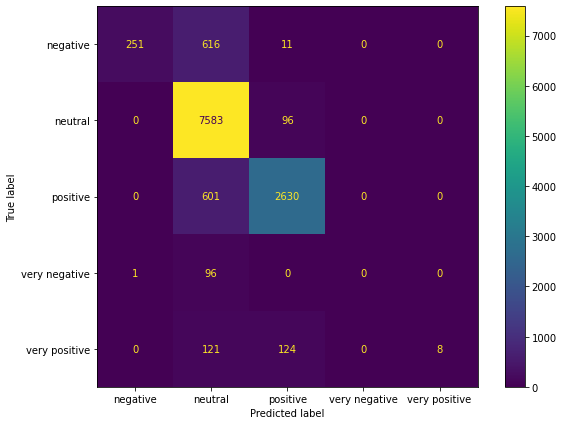


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.014     0.800     0.028         5
      neutral      0.959     0.721     0.823      3342
     positive      0.468     0.771     0.583       669
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.730      4016
    macro avg      0.288     0.458     0.287      4016
 weighted avg      0.876     0.730     0.782      4016


Confusion matrix for test set


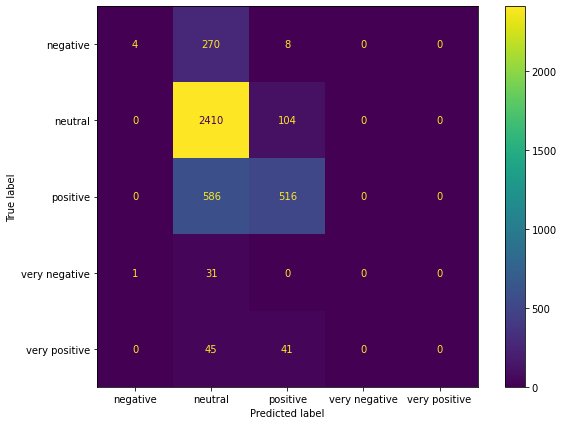

In [16]:
svc = SVC(kernel='rbf')
svc_model = svc.fit(train_features,train_labels)
train_pred = svc_model.predict(train_features)
y_pred = svc_model.predict(test_features)
evaluation_summary('SVC-one hot',train_pred,train_labels, y_pred,test_labels, train_features,test_features,svc_model)

**Decision Tree Classifier**

		 Decision Tree with TF-IDF

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      1.000     1.000     1.000       878
      neutral      1.000     0.999     1.000      7686
     positive      0.998     1.000     0.999      3227
very negative      0.979     1.000     0.990        95
very positive      0.992     0.996     0.994       252

     accuracy                          0.999     12138
    macro avg      0.994     0.999     0.996     12138
 weighted avg      0.999     0.999     0.999     12138


Confusion matrix for train set


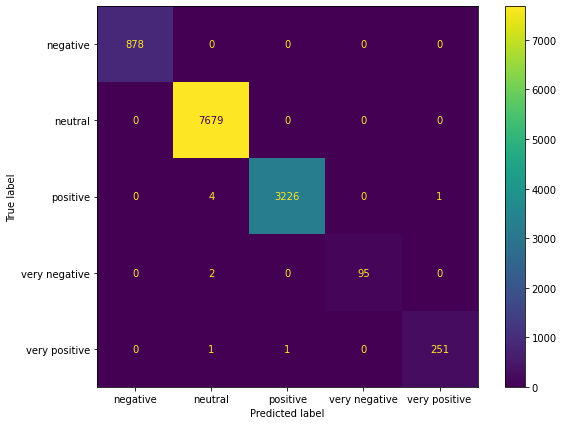


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.365     0.424     0.392       243
      neutral      0.787     0.773     0.780      2559
     positive      0.600     0.601     0.600      1100
very negative      0.281     0.273     0.277        33
very positive      0.395     0.420     0.407        81

     accuracy                          0.694      4016
    macro avg      0.486     0.498     0.491      4016
 weighted avg      0.698     0.694     0.696      4016


Confusion matrix for test set


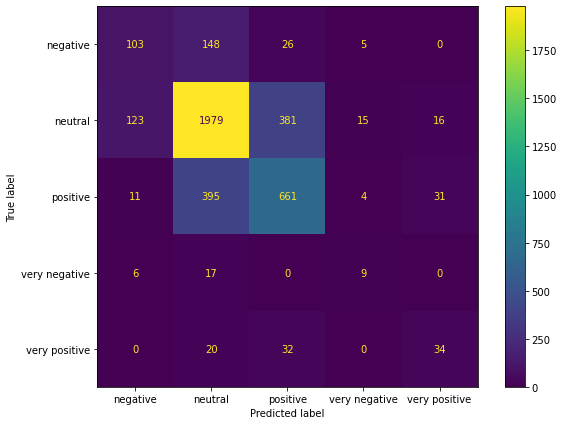

In [17]:
dtc = DecisionTreeClassifier().fit(train_features_tfidf,train_labels)
train_pred = dtc.predict(train_features_tfidf)
y_pred = dtc.predict(test_features_tfidf)
evaluation_summary('Decision Tree with TF-IDF',train_pred,train_labels, y_pred,test_labels, train_features_tfidf,test_features_tfidf,dtc)

# **Best Baseline model based on f1 score is Decision tree**

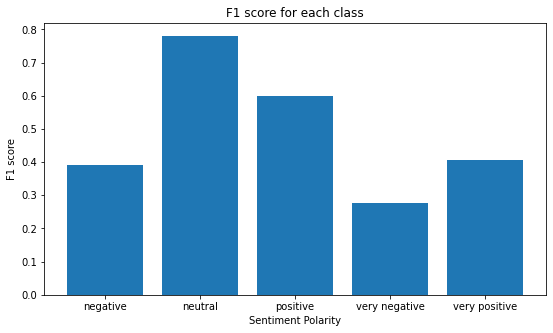

In [18]:
#Get the metrics from classification report and store in a dataframe
best_model_report = classification_report(y_pred, test_labels, digits=3, zero_division = 0, output_dict = True)
report_df = pd.DataFrame(best_model_report).transpose()
#plot the f1 score for each class type
plt.figure(figsize=(9,5))
plt.bar(x=report_df.index[:5], height= report_df['f1-score'][:5])
plt.xticks([0,1,2,3,4],le.classes_)
plt.xlabel('Sentiment Polarity')
plt.ylabel('F1 score')
plt.title('F1 score for each class')
plt.show()

# **Creating a pipeline**

In [19]:
#Base Line model
prediction_pipeline = Pipeline([
              ('Tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize)),
              ('logreg', LogisticRegression(solver='saga', max_iter=8000))
              ])

# **Parameter Tuning**

In [20]:
#Parameters to tune 
params = {
    'Tf-idf__sublinear_tf':(True,False),
    'Tf-idf__max_features': [1000,3000,4000,5000],
    'Tf-idf__max_df': ( 0.5, 0.75,1),
    'Tf-idf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logreg__C': [0.1,1,5,10], 
}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(train_data['body'], train_labels)

#get best parameters
print(grid_search.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
{'Tf-idf__max_df': 0.75, 'Tf-idf__max_features': 3000, 'Tf-idf__ngram_range': (1, 1), 'Tf-idf__sublinear_tf': False, 'logreg__C': 10}


		 Logistic Regression Before tuning

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.187     0.911     0.310       180
      neutral      0.977     0.795     0.877      9437
     positive      0.677     0.890     0.769      2458
very negative      0.041     1.000     0.079         4
very positive      0.221     0.949     0.359        59

     accuracy                          0.817     12138
    macro avg      0.421     0.909     0.479     12138
 weighted avg      0.901     0.817     0.844     12138


Confusion matrix for train set


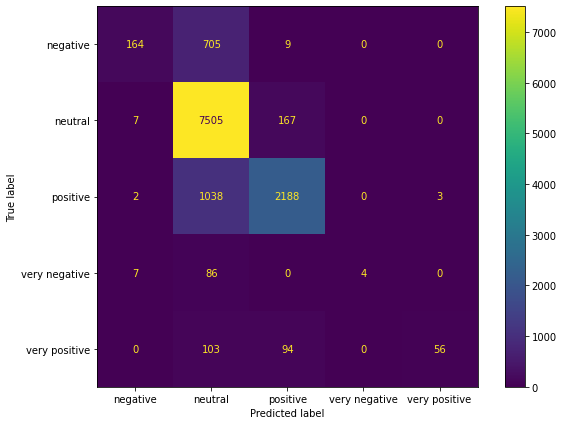


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.089     0.625     0.155        40
      neutral      0.944     0.738     0.829      3212
     positive      0.517     0.758     0.615       752
very negative      0.000     0.000     0.000         0
very positive      0.105     0.750     0.184        12

     accuracy                          0.741      4016
    macro avg      0.331     0.574     0.356      4016
 weighted avg      0.853     0.741     0.780      4016


Confusion matrix for test set


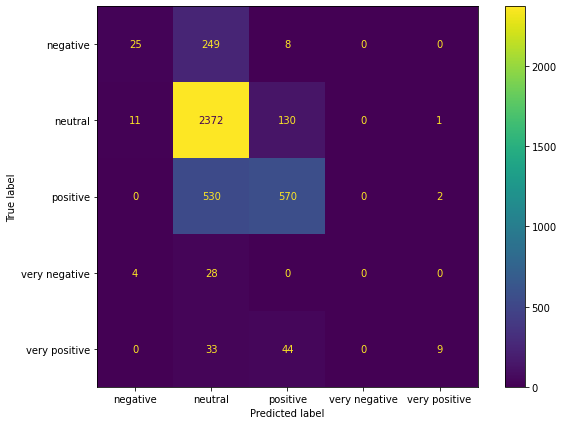

		 Logistic regression after tuning

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.736     0.963     0.834       671
      neutral      0.974     0.913     0.943      8189
     positive      0.860     0.925     0.891      3003
very negative      0.649     0.955     0.773        66
very positive      0.806     0.976     0.883       209

     accuracy                          0.920     12138
    macro avg      0.805     0.946     0.865     12138
 weighted avg      0.928     0.920     0.922     12138


Confusion matrix for train set


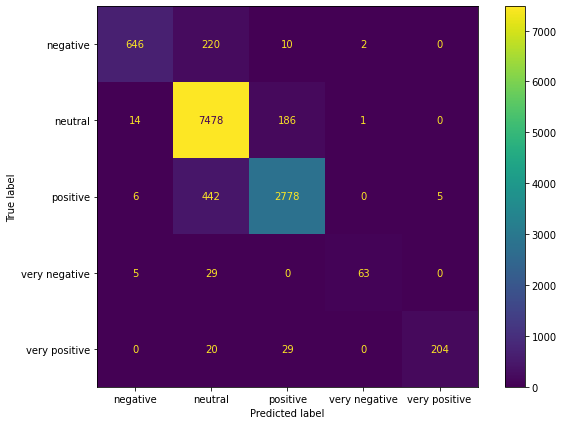


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.312     0.587     0.407       150
      neutral      0.892     0.799     0.843      2807
     positive      0.676     0.740     0.706      1007
very negative      0.156     0.833     0.263         6
very positive      0.279     0.522     0.364        46

     accuracy                          0.773      4016
    macro avg      0.463     0.696     0.517      4016
 weighted avg      0.808     0.773     0.786      4016


Confusion matrix for test set


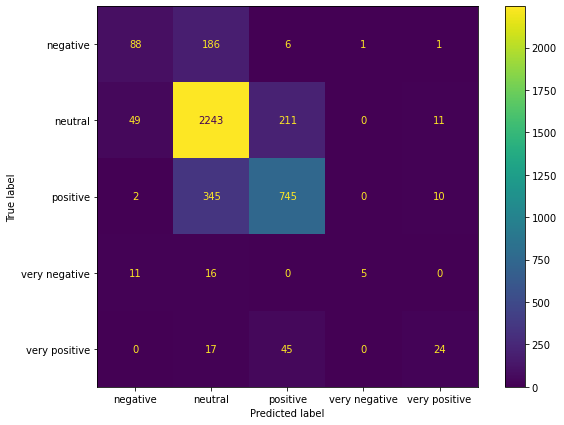

In [21]:
#BaseLine model

prediction_pipeline.fit(train_data['body'], train_labels)
#predict on train data
train_pred = prediction_pipeline.predict(train_data['body'])
#predict on test data
val_pred = prediction_pipeline.predict(test_data['body'])
#print the metrics
evaluation_summary('Logistic Regression Before tuning',train_pred,train_labels, val_pred,test_labels, train_data['body'],test_data['body'],prediction_pipeline)


#Added best parameters
tuned_pipeline = Pipeline([
              ('Tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=3250,ngram_range=(1,1),max_df=0.75,sublinear_tf=False,smooth_idf=False)),
              ('logreg', LogisticRegression(solver='saga', max_iter=8000,C=10))
              ])
tuned_pipeline.fit(train_data['body'], train_labels)
train_pred = tuned_pipeline.predict(train_data['body'])
val_pred = tuned_pipeline.predict(test_data['body'])

evaluation_summary('Logistic regression after tuning',train_pred,train_labels, val_pred,test_labels, train_data['body'],test_data['body'],tuned_pipeline)

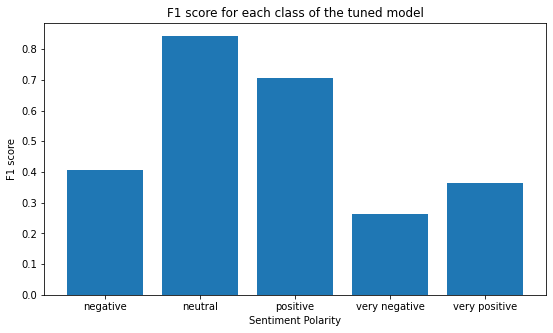

In [22]:
tuned_model_report = classification_report(val_pred, test_labels, digits=3, zero_division = 0, output_dict = True)
tuned_report = pd.DataFrame(tuned_model_report).transpose()
plt.figure(figsize=(9,5))
plt.bar(x=tuned_report.index[:5], height= tuned_report['f1-score'][:5])
plt.xticks([0,1,2,3,4],le.classes_)
plt.xlabel('Sentiment Polarity')
plt.ylabel('F1 score')
plt.title('F1 score for each class of the tuned model')

plt.show()

# **Error Analysis**

In [23]:
# creating a dataframe on the test data and analyse the classification
err_df = test_data[['body','sentiment.polarity']].copy()
err_df['y_pred'] = le.inverse_transform(val_pred)

err_df['y_pred'].value_counts()

neutral          2807
positive         1007
negative          150
very positive      46
very negative       6
Name: y_pred, dtype: int64

In [24]:
# A function to create word cloud, which would help to analyse the words

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def word_cloud_gen(df, title):
    words = ''
    for val in df:
        # typecaste each val to string
        val = str(val)
        # split the value
        tokens = val.split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = stopwords,min_font_size = 10).generate(words)
    
    plt.figure(figsize = (8, 8),facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

**Error Analysis on Very negative comments**

In [25]:
pd.set_option('display.max_colwidth', None)
_ = err_df[err_df['sentiment.polarity'] == 'very negative']
print('Correct class is Very negative,  predictied classes are\n',_['y_pred'].value_counts())
_[['body','y_pred']]

Correct class is Very negative,  predictied classes are
 neutral          16
negative         11
very negative     5
Name: y_pred, dtype: int64


,body,y_pred
56,I hate you now.,negative
308,Sir! ADRIANA FUCKING LIMA is an 11. Where did you learn your math. Check yourself before you wreck yourself!,negative
543,"On the worst case, it couldn't restore (if you have really bad luck)",negative
631,edit: [Question]\n\nthis is NOT a tutorial.,neutral
763,"I am using a 7970M on a P170EM laptop, getting an AMD GPU was the worst decision i could have made with this laptop. I regret not looking deeper into it.",neutral
827,Chaox :(,neutral
868,Herpes.\n\n:(,neutral
961,"....I thought something was up, figured it was just in my head that they were sitting there for too long...Well, now I feel like a moron.",neutral
1208,The uncompleteable missions are a bit annoying but oh well.,negative
1401,that's the worst answer I've ever heard.,very negative


	Words occured on correctly predicted class


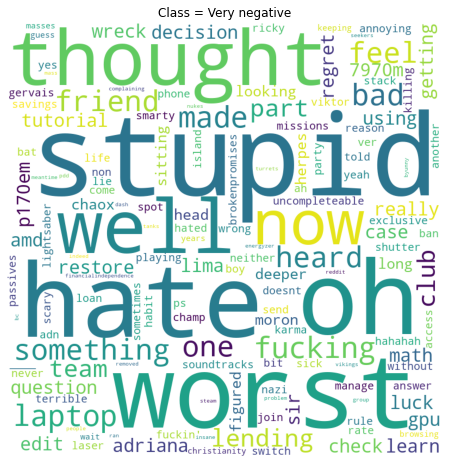

	Words occured on mispredicted class


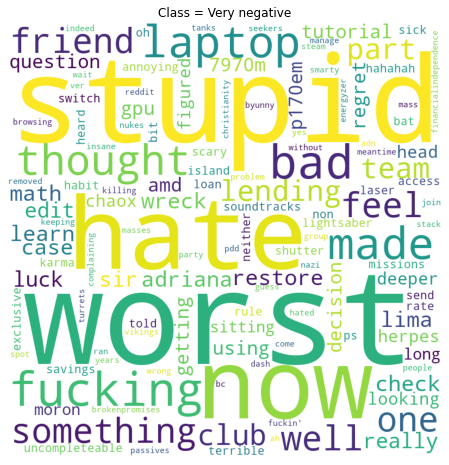

In [26]:
print('\tWords occured on correctly predicted class')
word_cloud_gen(_['body'], 'Class = Very negative')
print('\tWords occured on mispredicted class')
word_cloud_gen(_['body'][err_df['y_pred'] != 'very negative'], 'Class = Very negative')

1. Looking at the very negative sentiments, I see a lot of things containing ' :( ' , which we removed, I think to us humans, we can understand this, may be replacing this sad face emoji, with a word like 'sadface' in the preprocessing step would have helped in increasing the accuracy.
2. Most of the very negative comments have been classified as neutral. I would have been happy, atleast if it was classified as Negative.
3. Only 5 were correctly predicted, this is very poor performance.
4. Looking at the word cloud, 'stupid' is the most appeared word in very negative comments, we can also see worst, hate.

**Error Analysis on Very positive comments**

In [27]:
pd.set_option('display.max_colwidth', None)
_ = err_df[err_df['sentiment.polarity'] == 'very positive']
print('Correct class is Very positive,  predictied classes are\n',_['y_pred'].value_counts())
_[['body','y_pred']].head(30)

Correct class is Very positive,  predictied classes are
 positive         45
very positive    24
neutral          17
Name: y_pred, dtype: int64


,body,y_pred
3,Wasn't that also an epic and awesome series? I remember it being one of the best series I had seen at that point.,very positive
49,Awesome album,very positive
102,"I’m an atheist but I like psalm 23, It’s quite a beautiful bit of writing. \n\nThis screen saver misunderstands its sentiment and misuses its poetry….\n",neutral
104,awesome,very positive
106,This is full of awesome !! I love it !! \n+Upvote,positive
143,Regardless I will keep consuming those minty mountains and that delightful rootbeer.,neutral
261,"""Is it made of people?""\n""Good question. No!""",positive
314,"No, but a perfect 10 beats 2 sixes anytime...Its a perfect 10 ;)",positive
386,Thank you! I will try updating those... I'm guessing the ones built into W7 aren't the best.,positive
396,The irony. If you dont talk.. you get reported for refusing to communicate with the team. LOL,positive


	Words occured on correctly predicted class


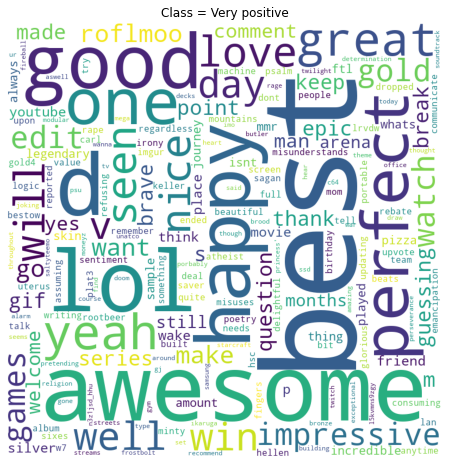

	Words occured on mispredicted class


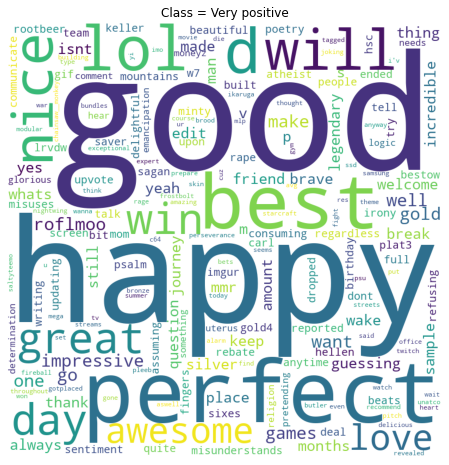

In [28]:
print('\tWords occured on correctly predicted class')
word_cloud_gen(_['body'], 'Class = Very positive')
print('\tWords occured on mispredicted class')
word_cloud_gen(_['body'][err_df['y_pred'] != 'very positive'], 'Class = Very positive')


* Here also I find a lot emoji's and some are misclassified. 
* May assigning a value to most commonly used emoji's could help in sentiment classification
* Seems like 'Awesome' appears most in the very positive comments. Most of the words here are positive

**Error Analysis for Negative class**

In [29]:
_ = err_df[err_df['sentiment.polarity'] == 'negative']
print('Correct class is negative,  predictied classes are\n',_['y_pred'].value_counts())
_[['body','y_pred']].head(30)

Correct class is negative,  predictied classes are
 neutral          186
negative          88
positive           6
very positive      1
very negative      1
Name: y_pred, dtype: int64


,body,y_pred
22,"Dresden with a monster healing factor is very, very scary.",negative
39,"Sometimes its the type of exercise. I hate being a group and running or competing. But get in me in a personal challenge sport and I'm all for it. I've taken up running as a challenge sport, trying to beat my mile times and going for longer and longer distances. Swimming too, trying to swim for longer periods of time.\n\nBTW, I use to hate running and never understood how anyone could do it for fun. Now I'm thinking about going for my first 5K in the spring.",neutral
50,"Ohhh my god dude, In my head I compiled a list of all the things that are wrong with the war on drugs and freedom country in general and then I was just amazed by the music....",neutral
59,When homework was just cutting and gluing,neutral
72,It steams when it's really cold out.,neutral
94,One that keeps their fucking hands off my children.,negative
174,"I've never experienced this before, but I got the Corsair CX600, and whenever I start up the machine or play games for a while, the PSU gets extremely loud. Restarting the computer or letting it stay off for a while does nothing, but I did find a weird solution. If I turn the computer on it's side, it quiets down immediately, but nothing else seems to work except that. Any idea's?",neutral
187,"Yes, the last game showing for me was 17 hours ago even though I played a couple since. Although my LP updated accordingly so at least something is tracking these games. NA here.",neutral
195,Failure to launch.,negative
203,I Can Do Bad All By Myself.,negative


	Words occured on correctly predicted class


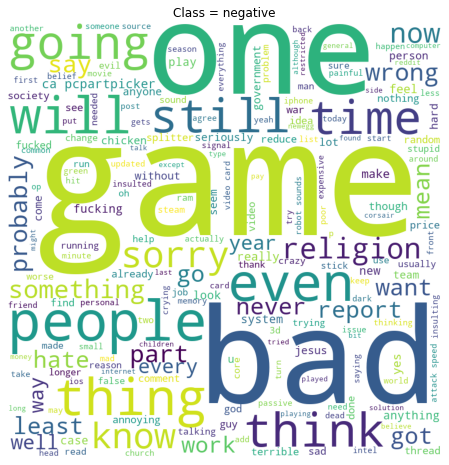

	Words occured on mispredicted class


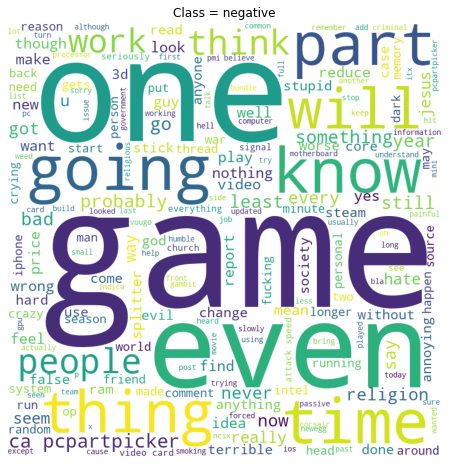

In [30]:
print('\tWords occured on correctly predicted class')
word_cloud_gen(_['body'], 'Class = negative')
print('\tWords occured on mispredicted class')
word_cloud_gen(_['body'][err_df['y_pred'] != 'negative'], 'Class = negative')

1. Most of the Negative comments have been classified as Neutral (2 times the negative)
2. But some the negative comments are really hard to find out, for example *'When homework was just cutting and gluing'*, It doesnt really have any negative words, and it is hard to classify them as negative, but the model made a pretty good job at classifying it as Neutral.

**Error Analysis for Positive class**

In [31]:
_ = err_df[err_df['sentiment.polarity'] == 'positive']
print('Correct class is positive,  predictied classes are\n',_['y_pred'].value_counts())
_[['body','y_pred']].head(30)

Correct class is positive,  predictied classes are
 positive         745
neutral          345
very positive     10
negative           2
Name: y_pred, dtype: int64


,body,y_pred
1,I find it cool that both Mana and Naama made it to the Ro16 in this DH Winter. Shows that they weren't just flashes in the pan.,positive
7,"Well if he was his own favorite, that would just be conceited.",positive
8,I think you are irrationally blaming me for something that is clearly his own damn fault,positive
10,Superman has a healing factor that is arguably better than Deadpool's since he doesn't leave scars. But why the hell would Superman need to heal from bullets and explosions the way Deadpool does? He's freaking Superman! I guess nothing changes.,positive
12,That happens a lot. Regular-Superman heals from Kryptonite stabbing/shooting/beatings beams pretty quickly after the rock is removed from his body. His healing factor is grossly underestimated on this subreddit.,positive
23,"Healing factor as in wound healing (including dismemberment and the like) or complete regeneration of life?\n\nIf its the latter, than Rai is almost unstoppable, if he can use his powers without worrying about draining his life\n\nIf it's the former, then a good boost, but he was practically untouchable to begin with",neutral
25,On a beach someplace warm and far away from anybody else.,neutral
27,"Sweden. Beautiful country, low crime, high prosperity, decent healthcare, strong education and social welfare, and home of Lisbeth Salandar and Pippi Longstocking.\n\nThe taxes are high as a mountain, but you actually get return on your investment.",positive
28,"Japan. Most my favorite foods, art styles, and other things are there.",positive
30,"If I could live anywhere, with nothing holding me back, I'd live on a countryside in Italy. I love the beauty of that country and it's people. I love the history it has. I love the Italian way of life and the language. I also love wine.",positive


	Words occured on correctly predicted class


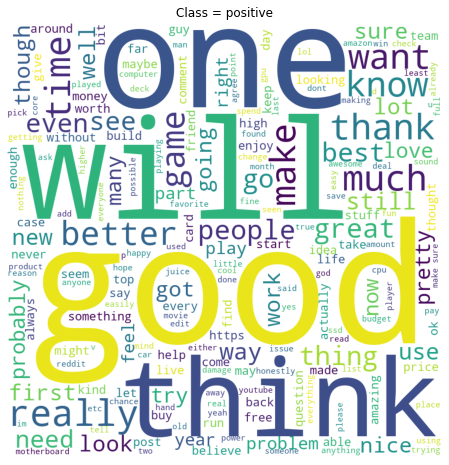

	Words occured on mispredicted class


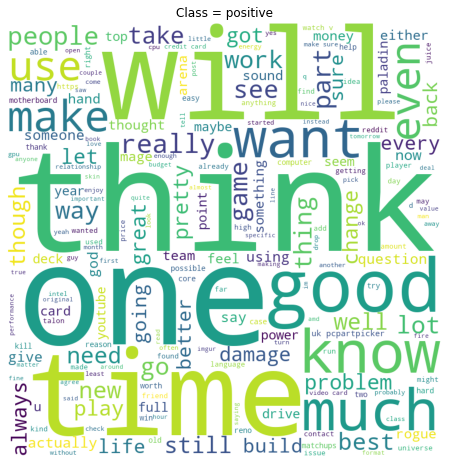

In [32]:
print('\tWords occured on correctly predicted class')
word_cloud_gen(_['body'], 'Class = positive')
print('\tWords occured on mispredicted class')
word_cloud_gen(_['body'][err_df['y_pred'] != 'positive'], 'Class = positive')

* Classifying positive and very positive is very tircky and also neutral comes to add further confusion 
* Looking at the data, I found a sentance containing only one word 'Happiness',even for me it is hard to classify it whether positive or very positive, the correct class is positive and it predicted very positive.
* The wordcloud shows, on the mispredicted classes, we cannot see the words that describes positivity much. I would have done the same if I were classify them.

**Error Analysis for neutral class**

In [33]:
_ = err_df[err_df['sentiment.polarity'] == 'neutral']
print('Correct class is neutral,  predictied classes are\n',_['y_pred'].value_counts())
_[['body','y_pred']].head(30)

Correct class is neutral,  predictied classes are
 neutral          2243
positive          211
negative           49
very positive      11
Name: y_pred, dtype: int64


,body,y_pred
0,Was watching a VOD from last years DreamHack Winter. The first map in the finals (Naama vs Mana) was Lost Temple.. spawning close ground positions..\n\nIt's a great sign that shows how much the game is evolving imo. Has anyone else noticed stuff like this?,positive
2,"Even better, watch a VOD from [MLG Raleigh](http://tv.majorleaguegaming.com/videos/174-wr4-g2-kiwikaki-vs-nadagast-steppes-of-war-mlg-raleigh-starcraft-2)\n\nThe games, the casting, the maps... everything was fucking awful. Amazing that it was just over one year ago.",positive
4,Basically what the title says.,neutral
5,Danny Phantom is definitely going to wreck some ghosts.,neutral
6,Your name and your post do not correlate,neutral
9,"If Deadpool's regen system doesn't let person get tired, then Godzilla would've just gotten better Stamina. His biggest problem is some of his enemies where him out, that's how Kiryu beat him",neutral
11,Deadpool just has scars because of the cancer doesn't he?\nWell stabbing him with kryptonite wouldn't be as effective since he'd heal straight away probably,neutral
13,"Been a while since I've seen kryptonite be actually used on him in New 52, so idk too much about his healing factor",neutral
14,"In the movie Doom, Superman had open heart surgery to remove a kryptonite bullet from his heart and 10 seconds after it came out the wound was fully healed. \n\nHe also got stabbed with Excalibur through his chest once (the comic in question eludes me atm). Then Batman pulled it out, and a few seconds after that he up and fighting. So yeah, it is a pretty damage strong healing factor.",neutral
15,Oh wow,neutral


	Words occured on correctly predicted class


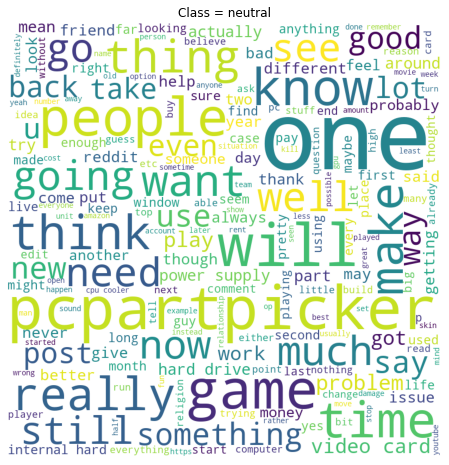

	Words occured on mispredicted class


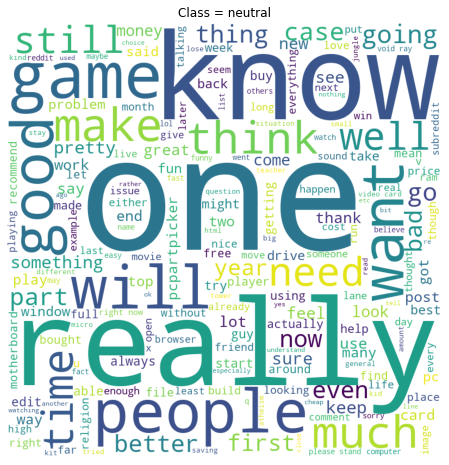

In [34]:
print('\tWords occured on correctly predicted class')
word_cloud_gen(_['body'], 'Class = neutral')
print('\tWords occured on mispredicted class')
word_cloud_gen(_['body'][err_df['y_pred'] != 'neutral'], 'Class = neutral')

* Most of the neutral class has been correctly classified, only 10 percent were misclassified.
* Some post with no content has been classified as neutral. And some posts contains the word 'deleted' only and it has been correctly classified.
* Looking at the word cloud, most words are neutral words, like they dont imply any emotions and the model did a job classifying them

# **Additional Features**

Added two new features - 'sentiment subjectivity' & 'majority type'

		 Logistic Regression with Added features

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.852     0.963     0.904       777
      neutral      0.974     0.956     0.965      7825
     positive      0.924     0.930     0.927      3208
very negative      0.948     0.979     0.963        94
very positive      0.885     0.957     0.920       234

     accuracy                          0.950     12138
    macro avg      0.917     0.957     0.936     12138
 weighted avg      0.951     0.950     0.950     12138


Confusion matrix for train set


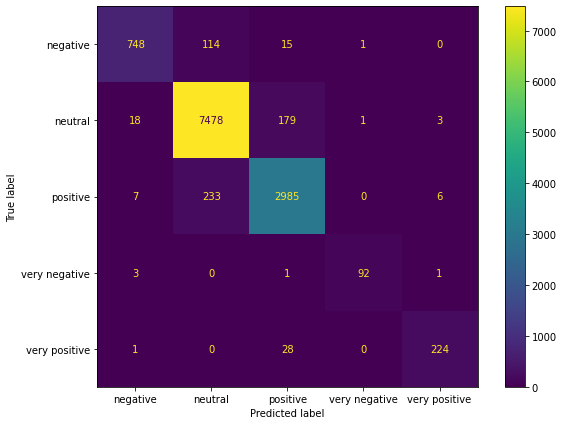


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.436     0.609     0.508       202
      neutral      0.894     0.853     0.873      2634
     positive      0.749     0.746     0.747      1106
very negative      0.375     0.571     0.453        21
very positive      0.349     0.566     0.432        53

     accuracy                          0.806      4016
    macro avg      0.560     0.669     0.603      4016
 weighted avg      0.821     0.806     0.812      4016


Confusion matrix for test set


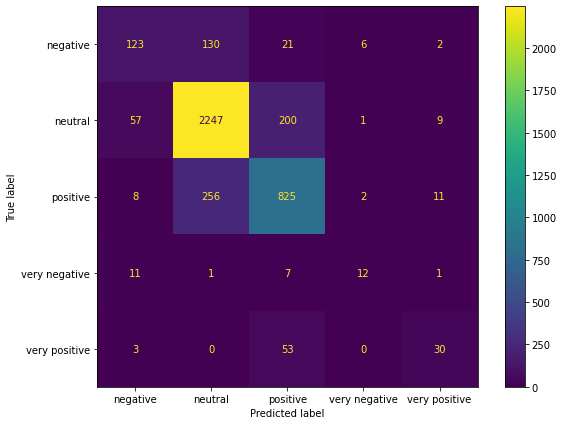

In [35]:
#For Numeric features

numeric_features =['sentiment.subjectivity']
numeric_transformer = StandardScaler()

#Categorical features
cat_features =['majority_type']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

text_features = ['body']
text_transformer = TfidfVectorizer(tokenizer=tokenize_normalize,max_features=3250,ngram_range=(1,1),max_df=0.75, sublinear_tf=False, smooth_idf=False)

#Using column transformer to combine columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat',cat_transformer, cat_features),
    ('text',text_transformer, 'body')
    ], remainder='drop')

# Classifying
clf = LogisticRegression(solver='saga',max_iter = 8000,C=10)
classifier = Pipeline(steps=[('preprocessing', preprocessor),
                     ('model',clf)])

classifier.fit(train_data,train_labels)
train_pred = classifier.predict(train_data)
y_pred = classifier.predict(test_data)
evaluation_summary('Logistic Regression with Added features',train_pred, train_labels, y_pred,test_labels, train_data,test_data,classifier)

# **Its Time to do feature Selection**

In [36]:
# Again initializing the vectorizer with the tuned parameters
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,max_features=3250,ngram_range=(1,1),max_df=0.75, sublinear_tf=False, smooth_idf=False)
train_features_ = tf_idf_vectorizer.fit_transform(train_data['body'])
validation_features_ = tf_idf_vectorizer.transform(validation_data['body'])
test_features_ = tf_idf_vectorizer.transform(test_data['body'])

train_features_df = pd.DataFrame(train_features_.toarray(), columns = tf_idf_vectorizer.get_feature_names())
test_features_df = pd.DataFrame(test_features_.toarray(), columns = tf_idf_vectorizer.get_feature_names())

In [37]:
#This function gets in features and returns only the sparse matrix of given subset of features
#This is used after feature selection
def stack_features(features):
    #Creating a dataframe to filter the needed features
    important_features = train_features_df.columns[features].copy()
    feature_selected_df = train_features_df[important_features]

    #Filtering the selected features for test set

    feature_selected_df_test = test_features_df[important_features].copy()

    #Adding two more features
    final = sp.sparse.hstack([sp.sparse.csr_matrix(feature_selected_df), pd.get_dummies(train_data['majority_type'])])
    final_test = sp.sparse.hstack([sp.sparse.csr_matrix(feature_selected_df_test), pd.get_dummies(test_data['majority_type'])])
    final = sp.sparse.hstack([final,sp.sparse.csr_matrix(train_data['sentiment.subjectivity']).T])
    final_test = sp.sparse.hstack([final_test,sp.sparse.csr_matrix(test_data['sentiment.subjectivity']).T])
    
    return final, final_test

**Chi Squared Test**

# **This is final model**

Combined model (final one)
		 Logistic Regression after Chi Squared feature selection

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.629     0.864     0.728       639
      neutral      0.937     0.890     0.913      8087
     positive      0.808     0.833     0.821      3134
very negative      0.866     0.966     0.913        87
very positive      0.692     0.916     0.788       191

     accuracy                          0.875     12138
    macro avg      0.786     0.894     0.833     12138
 weighted avg      0.884     0.875     0.878     12138


Confusion matrix for train set


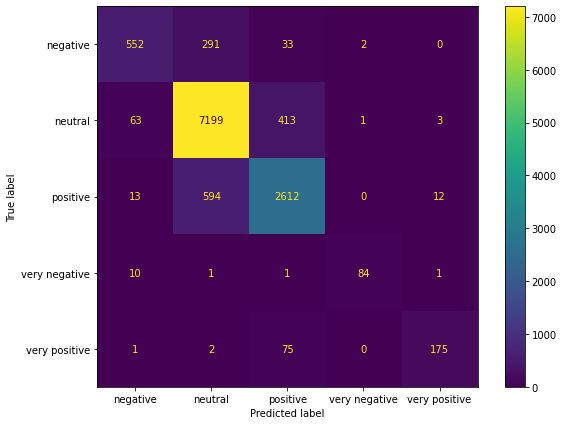


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.422     0.633     0.506       188
      neutral      0.907     0.855     0.880      2667
     positive      0.759     0.770     0.764      1086
very negative      0.438     0.737     0.549        19
very positive      0.430     0.661     0.521        56

     accuracy                          0.818      4016
    macro avg      0.591     0.731     0.644      4016
 weighted avg      0.835     0.818     0.824      4016


Confusion matrix for test set


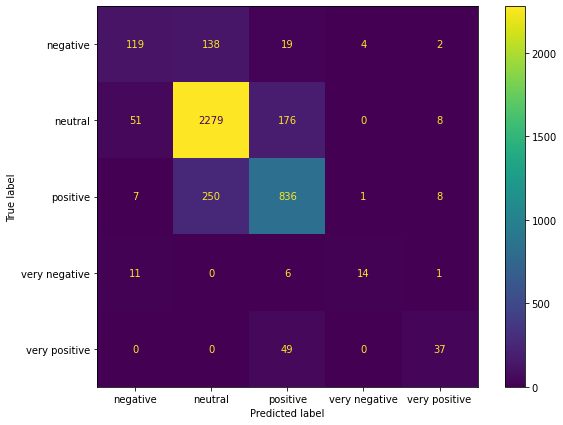

In [38]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

#K number of features
select_k = 800
selection = SelectKBest(chi2, k=select_k).fit(train_features_df, train_labels)

final, final_test = stack_features(selection.get_support())

#Train the classifier again to evaluate the performance
clf = LogisticRegression(solver='saga',max_iter = 8000,C=10)
clf = clf.fit(final, train_labels)
train_pred = clf.predict(final)
y_pred = clf.predict(final_test)
print('Combined model (final one)')
evaluation_summary('Logistic Regression after Chi Squared feature selection',train_pred, train_labels, y_pred,test_labels, final, final_test, clf)

**Lets Do L1 regularization**

		 Logistic Regression after L1 feature selection

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.612     0.856     0.714       627
      neutral      0.940     0.894     0.916      8076
     positive      0.819     0.831     0.825      3186
very negative      0.722     0.946     0.819        74
very positive      0.609     0.880     0.720       175

     accuracy                          0.875     12138
    macro avg      0.740     0.881     0.799     12138
 weighted avg      0.885     0.875     0.878     12138


Confusion matrix for train set


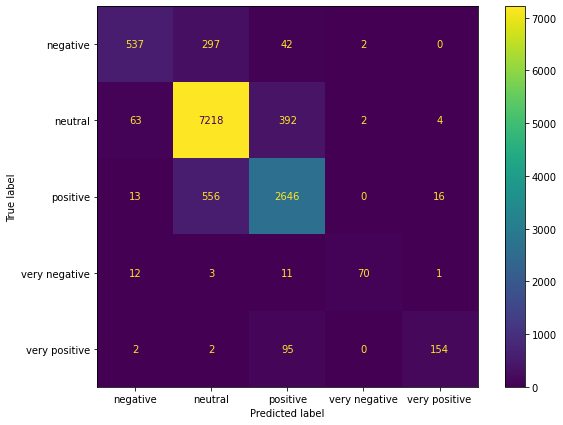


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.411     0.592     0.485       196
      neutral      0.899     0.849     0.873      2662
     positive      0.747     0.763     0.755      1078
very negative      0.469     0.714     0.566        21
very positive      0.442     0.644     0.524        59

     accuracy                          0.810      4016
    macro avg      0.593     0.712     0.641      4016
 weighted avg      0.825     0.810     0.816      4016


Confusion matrix for test set


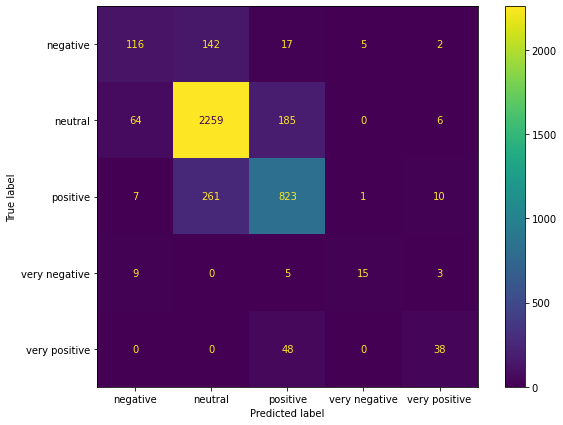

In [39]:
from sklearn.feature_selection import SelectFromModel

embd_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear')).fit(train_features_df, train_labels)

final, final_test = stack_features(embd_selector.get_support())

#Train the classifier again to evaluate the performance
clf = LogisticRegression(solver='saga',max_iter = 8000,C=10)
clf = clf.fit(final, train_labels)
train_pred = clf.predict(final)
y_pred = clf.predict(final_test)
evaluation_summary('Logistic Regression after L1 feature selection',train_pred, train_labels, y_pred,test_labels, final, final_test, clf)

**Lets try with Random Forest feature importance**

		 Logistic Regression after Random Forest feature selection

		Evaluation for training set 

               precision    recall  f1-score   support

     negative      0.556     0.811     0.659       602
      neutral      0.927     0.873     0.899      8153
     positive      0.775     0.803     0.789      3120
very negative      0.742     0.947     0.832        76
very positive      0.644     0.872     0.741       187

     accuracy                          0.853     12138
    macro avg      0.729     0.861     0.784     12138
 weighted avg      0.864     0.853     0.856     12138


Confusion matrix for train set


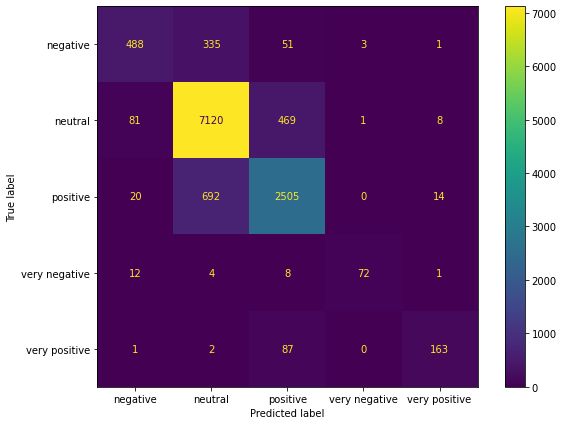


		Evaluation for test set 

               precision    recall  f1-score   support

     negative      0.397     0.574     0.470       195
      neutral      0.893     0.848     0.870      2645
     positive      0.735     0.743     0.739      1090
very negative      0.438     0.667     0.528        21
very positive      0.430     0.569     0.490        65

     accuracy                          0.801      4016
    macro avg      0.579     0.680     0.619      4016
 weighted avg      0.816     0.801     0.807      4016


Confusion matrix for test set


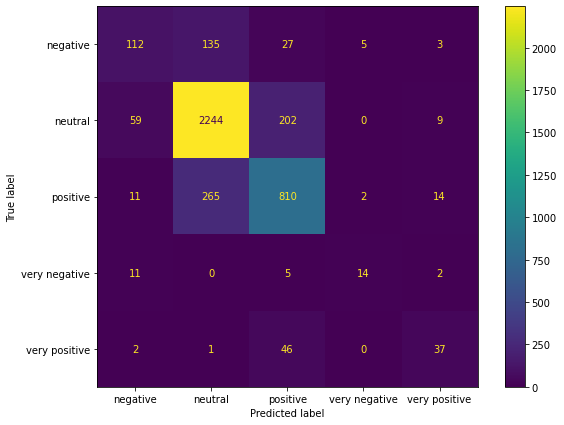

In [40]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier().fit(train_features_df, train_labels)

importance = rfc.feature_importances_

rfc_df = pd.DataFrame({"Features": train_features_df.columns, "Importances":importance})
important_features = rfc_df.sort_values('Importances', ascending=False)

features = rfc_df['Importances']>= rfc_df['Importances'].mean()
final, final_test = stack_features(features)

#Train the classifier again to evaluate the performance
clf = LogisticRegression(solver='saga',max_iter = 8000,C=10)
clf = clf.fit(final, train_labels)
train_pred = clf.predict(final)
y_pred = clf.predict(final_test)
evaluation_summary('Logistic Regression after Random Forest feature selection',train_pred, train_labels, y_pred,test_labels, final, final_test, clf)

In [53]:
df_plot = pd.DataFrame(['Accuracy', 'Precision', 'Recall', 'F1 score'])
df_plot['Baseline'] = [74.1,33.1,57.4,35.6]
df_plot['Final model'] = [81.8,59.1,73.1,64.4]

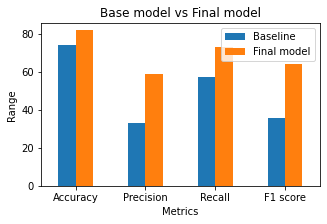

In [62]:
df_plot.plot(x = 0, y = ['Baseline', 'Final model'], kind='bar', figsize = (5,3), rot = 0)
plt.xlabel('Metrics')
plt.ylabel('Range')
plt.title('Base model vs Final model')
plt.show()